# EV Charging Network Challenge

## Problem Statement 
`To optimally place EV charging stations, so that the configuration remains robust to demographic changes.`

##### Notations and Constants
* 𝑖 = Index of the demand point. 𝑖 varies from 0 to 4095
* 𝑗 = Index of the supply point (parking location). 𝑗𝑗 varies from 0 to 99
* 𝐷𝑖 = EV charging demand at 𝑖𝑡ℎ demand point.
* 𝑆CS𝑗 = Number of slow charging stations at 𝑗𝑡ℎ supply point
* 𝐹CS𝑗 = Number of fast charging stations at 𝑗𝑡ℎ supply point
* 𝑃S𝑗 = Total parking slots available at 𝑗𝑡ℎ supply point
* 𝐶apscs = Charging capacity of a slow charging station = 20
* 𝐶apfcs = Charging capacity of a slow charging station = 400
* 𝑆max𝑗 = Maximum supply that can be given from 𝑗𝑡ℎ supply point = (𝐶apscs × 𝑆CS𝑗) + (𝐶apfcs × FCS𝑗)
* 𝐷ist𝑖j = Distance between 𝑖𝑡ℎ demand point and 𝑗𝑡ℎ supply point (Distance matrix)
* 𝐷S𝑖j = How much demand of the 𝑖𝑡ℎ demand point is satisfied by the 𝑗𝑡ℎ supply point (Demand-Supply matrix)

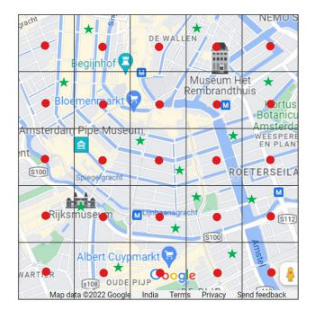

In [23]:
figure(figsize=(5, 5), dpi=80)
img = mpimg.imread('Capture.jpg')
plt.axis('off')
plt.imshow(img)

## Approach

* Train-Test split: Trainng - 2010-2017 & Testing - 2018 
* Create baseline model using moving average 
* Use linear regression, random forest and other tree based regression algorithms to ascertain EV Charging demand 
* 

In [39]:
#setting up W&B for Experiemnt tracking
#!pip install --upgrade -q wandb
import wandb
from wandb.keras import WandbCallback

wandb.login(key='0108020bf5d0a6642b207fc7ebc81bdfef3f89d3')
wandb.login()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\DELL/.netrc


True

In [173]:
#Importing libraries
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.image as mpimg
from matplotlib.pyplot import figure
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

In [207]:
#reading the data
demand = pd.read_csv('Demand_History.csv')
supply = pd.read_csv('exisiting_EV_infrastructure_2018.csv')

#Data quality checks done
* No null values 
* data type as float for all numerical features

## Feature Engineering and EDA

##### Highlights
* Strong autocorrelation observed
* Different, inconsitent data distribution observed, which makes generalisation a challenge
* For each grid, EV demand follows a similar pattern every year
* No outliers
* Derived Features i) YoY growth rates have been determined ii) Avg. growth rate has been derived
* Grid clusters will be created using kmeans followed by creating a categorical feature 

In [208]:
demand.head()

,demand_point_index,x_coordinate,y_coordinate,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,0,0.5,0.5,0.352242,0.667932,0.958593,2.911901,4.338274,6.561995,8.454417,10.595324,13.119572
1,1,1.5,0.5,0.325940,0.591964,0.862652,2.589068,4.196034,5.745551,8.753195,11.126995,12.020091
2,2,2.5,0.5,0.373752,0.591890,0.969733,2.641432,3.541772,5.469161,8.414627,10.115336,14.018254
3,3,3.5,0.5,0.420686,0.584055,0.906547,2.378577,3.888121,5.846089,9.083868,12.424885,15.012302
4,4,4.5,0.5,0.475621,0.647940,0.981544,2.665400,4.218711,6.776609,8.851107,11.731131,16.355563


In [209]:
#transposing the demand DF 
demand1=demand.transpose()

In [210]:
demand_t = demand1.iloc[3: , :]
demand_t

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
2010,0.352242,0.325940,0.373752,0.420686,0.475621,0.380156,0.449348,0.470071,0.537307,0.445734,...,0.114351,0.075160,0.081059,0.083821,0.158356,0.171015,0.041716,0.100895,0.155353,0.209372
2011,0.667932,0.591964,0.591890,0.584055,0.647940,0.725189,0.730466,0.866474,0.833661,0.775279,...,0.185420,0.131877,0.138802,0.158354,0.376271,0.334565,0.061741,0.180352,0.290825,0.340185
2012,0.958593,0.862652,0.969733,0.906547,0.981544,1.076054,1.220484,1.615454,1.622691,1.316209,...,0.489806,0.298811,0.227962,0.393987,0.670141,0.556055,0.131291,0.296299,0.557803,0.749491
2013,2.911901,2.589068,2.641432,2.378577,2.665400,2.762618,2.655187,3.273061,3.366533,3.795858,...,1.285151,0.819191,0.604009,0.966916,1.584710,1.373291,0.386540,0.705373,1.516066,1.904285
2014,4.338274,4.196034,3.541772,3.888121,4.218711,4.220747,5.333594,5.442867,5.973267,4.781361,...,2.168647,1.086649,1.012104,1.703340,2.272350,1.837586,0.755846,1.300220,2.399426,2.775772
2015,6.561995,5.745551,5.469161,5.846089,6.776609,6.760395,8.620496,8.681284,10.033183,9.277640,...,3.320948,1.427004,1.158568,2.083558,3.635703,2.517146,0.941116,1.608609,2.719197,3.404641
2016,8.454417,8.753195,8.414627,9.083868,8.851107,9.331196,11.406751,11.135352,13.210567,10.992479,...,4.336336,1.924844,1.350226,2.802044,5.880033,3.352280,1.107797,1.822806,4.494515,4.574922
2017,10.595324,11.126995,10.115336,12.424885,11.731131,14.743943,13.115854,14.708272,17.291626,17.386210,...,6.095297,2.054926,1.598313,3.284002,7.672174,4.149888,1.309479,2.333681,6.096858,6.301078
2018,13.119572,12.020091,14.018254,15.012302,16.355563,17.559998,19.696415,19.367417,21.899847,21.765241,...,6.625857,3.612612,2.643128,4.127373,7.833432,5.426193,2.057450,3.218519,6.262574,6.860939


<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

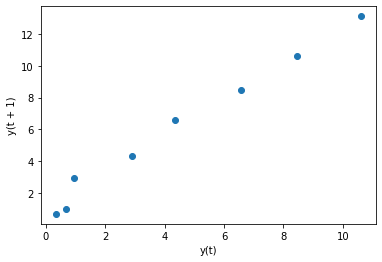

In [211]:
#checking autocorrelation
df=demand_t[0]
pd.plotting.lag_plot(df, lag=1)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

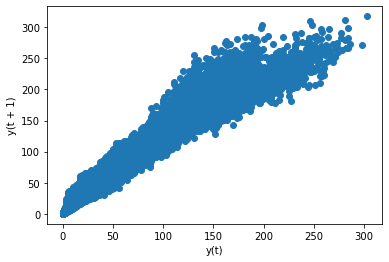

In [212]:
pd.plotting.lag_plot(demand_t, lag=1)

In [213]:
#Describing the demand data 
demand.describe()

,demand_point_index,x_coordinate,y_coordinate,2010,2011,2012,2013,2014,2015,2016,2017,2018
count,4096.00000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000
mean,2047.50000,32.000000,32.000000,1.993306,4.017967,7.552549,19.323394,31.891712,42.249471,58.718724,75.805574,88.264071
std,1182.55768,18.475209,18.475209,1.849883,4.003144,7.658317,19.080365,31.270080,39.501338,56.133565,76.390728,79.513884
min,0.00000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1023.75000,16.250000,16.250000,0.474756,0.898346,1.613829,4.480010,6.958344,10.634926,15.245858,22.668290,25.275349
50%,2047.50000,32.000000,32.000000,1.163430,2.134510,3.854949,10.045907,17.872258,24.146146,31.755415,37.285351,54.567937
75%,3071.25000,47.750000,47.750000,3.665382,6.996849,13.579687,34.418367,56.016385,77.892036,108.528007,138.112588,158.637564
max,4095.00000,63.500000,63.500000,6.641083,14.961144,28.383260,70.789208,117.063595,148.491476,219.652855,302.729826,317.422418


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

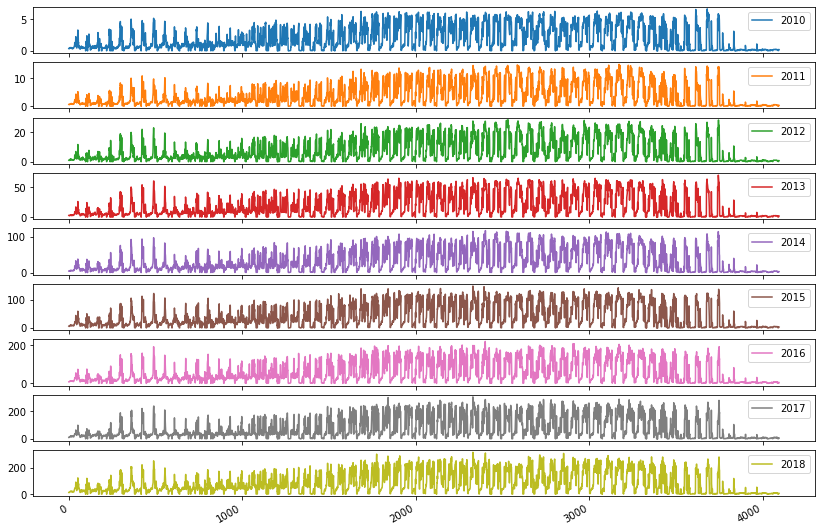

In [214]:
demand_vis = demand[['2010','2011','2012','2013','2014','2015','2016','2017','2018']]
demand_vis.plot(subplots=True, figsize=(14, 10))

In [215]:
demand_vis.head()

,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,0.352242,0.667932,0.958593,2.911901,4.338274,6.561995,8.454417,10.595324,13.119572
1,0.325940,0.591964,0.862652,2.589068,4.196034,5.745551,8.753195,11.126995,12.020091
2,0.373752,0.591890,0.969733,2.641432,3.541772,5.469161,8.414627,10.115336,14.018254
3,0.420686,0.584055,0.906547,2.378577,3.888121,5.846089,9.083868,12.424885,15.012302
4,0.475621,0.647940,0.981544,2.665400,4.218711,6.776609,8.851107,11.731131,16.355563


array([[<AxesSubplot:title={'center':'2010'}>,
        <AxesSubplot:title={'center':'2011'}>,
        <AxesSubplot:title={'center':'2012'}>],
       [<AxesSubplot:title={'center':'2013'}>,
        <AxesSubplot:title={'center':'2014'}>,
        <AxesSubplot:title={'center':'2015'}>],
       [<AxesSubplot:title={'center':'2016'}>,
        <AxesSubplot:title={'center':'2017'}>,
        <AxesSubplot:title={'center':'2018'}>]], dtype=object)

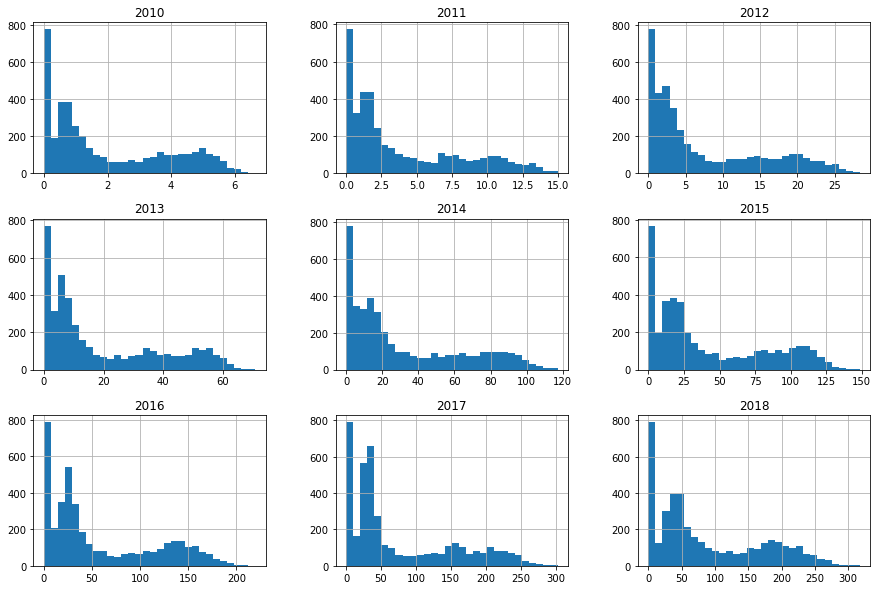

In [216]:
#Univariate analysis
demand_vis.hist(bins=30, figsize=(15, 10))

In [217]:
import plotly.express as px
fig = px.scatter_matrix(demand_vis, width=1000, height=1200)
fig.show()

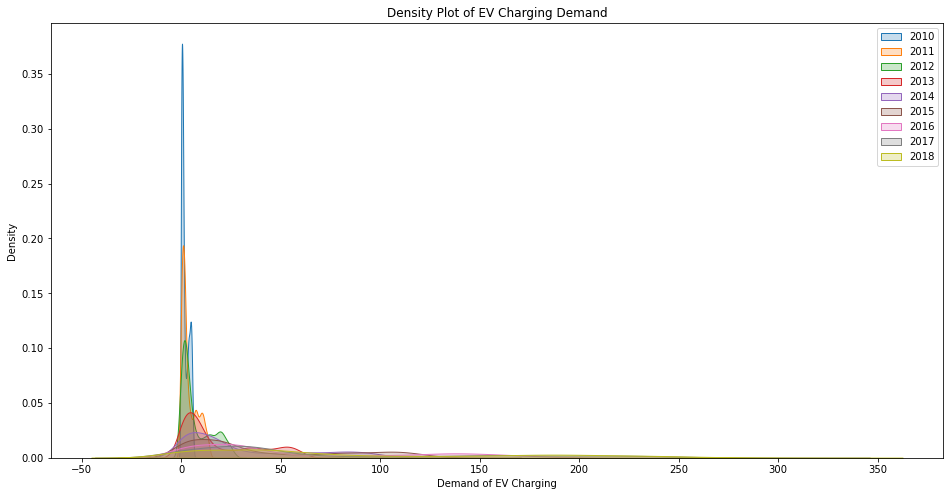

In [218]:
#checking probability density for each year
plt.figure(figsize=(16,8))
ax = sns.kdeplot(demand_vis["2010"], shade=True)
sns.kdeplot(demand_vis["2011"], shade=True)
sns.kdeplot(demand_vis["2012"], shade=True)
sns.kdeplot(demand_vis["2013"], shade=True)
sns.kdeplot(demand_vis["2014"], shade=True)
sns.kdeplot(demand_vis["2015"], shade=True)
sns.kdeplot(demand_vis["2016"], shade=True)
sns.kdeplot(demand_vis["2017"], shade=True)
sns.kdeplot(demand_vis["2018"], shade=True)
plt.legend(['2010', '2011', '2012', '2013','2014','2015', '2016','2017','2018'])
plt.title('Density Plot of EV Charging Demand')
ax.set(xlabel= 'Demand of EV Charging')
ax.set(ylabel='Density')
plt.grid(False)
plt.show()

<AxesSubplot:>

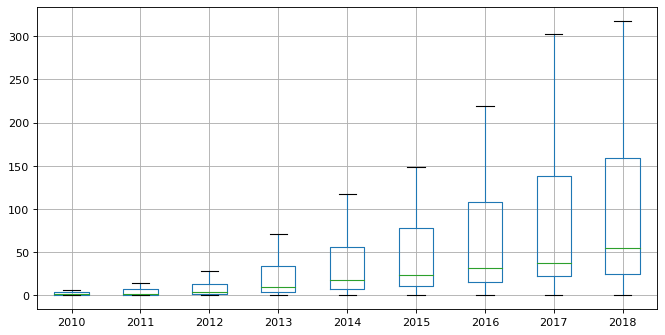

In [219]:
figure(figsize=(10, 5), dpi=80)
demand_vis.boxplot()

In [220]:
#creating new features-YoY growth in EV demand & avg. growth rate  
demand_growth = demand[['2010','2011','2012','2013','2014','2015','2016','2017','2018']]
demand_growth['delta_11_10'] = (demand_growth['2011'] - demand_growth['2010']) 
demand_growth['delta_12_11'] = ((demand_growth['2012'] - demand_growth['2011']))
demand_growth['delta_13_12'] = ((demand_growth['2013'] - demand_growth['2012']))
demand_growth['delta_14_13'] = ((demand_growth['2014'] - demand_growth['2013']))
demand_growth['delta_15_14'] = ((demand_growth['2015'] - demand_growth['2014']))
demand_growth['delta_16_15'] = ((demand_growth['2016'] - demand_growth['2015']))
demand_growth['delta_17_16'] = ((demand_growth['2017'] - demand_growth['2016'])) 
demand_growth['delta_18_17'] = ((demand_growth['2018'] - demand_growth['2017']))
demand_growth['avg_delta'] = (demand_growth['delta_11_10']+demand_growth['delta_12_11']+demand_growth['delta_13_12']+demand_growth['delta_14_13']+demand_growth['delta_15_14']+demand_growth['delta_16_15']+demand_growth['delta_17_16']+demand_growth['delta_18_17'])/8

<ipython-input-220-3dc18e5e246c>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-220-3dc18e5e246c>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [221]:
#demand_growth['growth_18_10'].describe()
#demand_growth.describe()
demand_growth.head()

,2010,2011,2012,2013,2014,2015,2016,2017,2018,delta_11_10,delta_12_11,delta_13_12,delta_14_13,delta_15_14,delta_16_15,delta_17_16,delta_18_17,avg_delta
0,0.352242,0.667932,0.958593,2.911901,4.338274,6.561995,8.454417,10.595324,13.119572,0.315690,0.290662,1.953307,1.426374,2.223720,1.892423,2.140907,2.524248,1.595916
1,0.325940,0.591964,0.862652,2.589068,4.196034,5.745551,8.753195,11.126995,12.020091,0.266024,0.270688,1.726416,1.606966,1.549517,3.007644,2.373800,0.893096,1.461769
2,0.373752,0.591890,0.969733,2.641432,3.541772,5.469161,8.414627,10.115336,14.018254,0.218138,0.377843,1.671699,0.900340,1.927388,2.945466,1.700709,3.902918,1.705563
3,0.420686,0.584055,0.906547,2.378577,3.888121,5.846089,9.083868,12.424885,15.012302,0.163368,0.322492,1.472030,1.509544,1.957968,3.237779,3.341017,2.587417,1.823952
4,0.475621,0.647940,0.981544,2.665400,4.218711,6.776609,8.851107,11.731131,16.355563,0.172319,0.333604,1.683855,1.553311,2.557898,2.074498,2.880024,4.624432,1.984993


<AxesSubplot:>

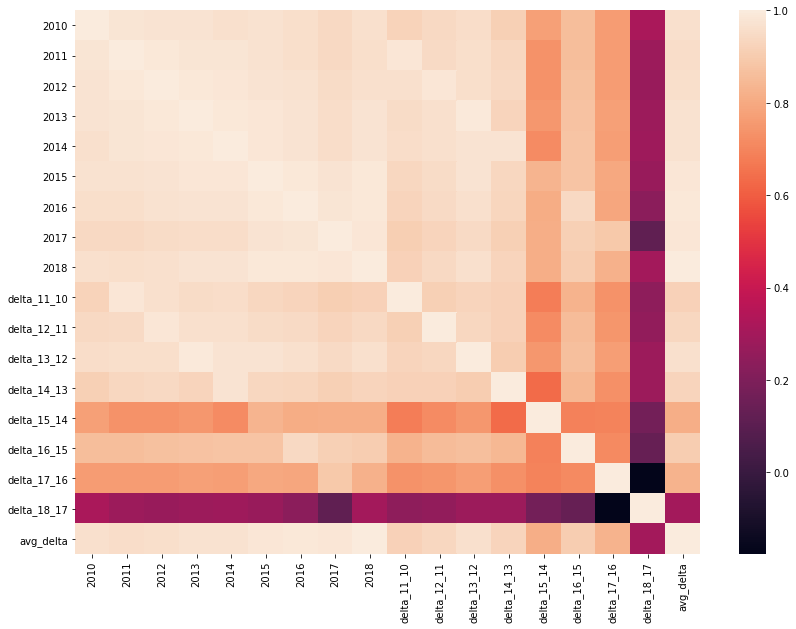

In [202]:
figure(figsize=(14,10))
sns.heatmap(demand_growth.corr())
#demand_growth.corr()

In [222]:
#creating clusters[0,1,2 - mid, low, high demand grids]
demand_clusters = demand_growth
scaler = StandardScaler()
scaled_demand_clusters= scaler.fit_transform(demand_clusters)

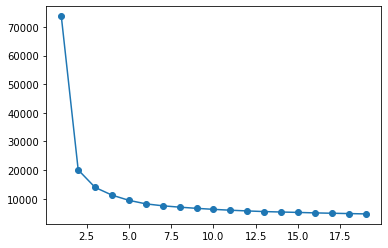

In [223]:
cluster_range = range(1,20)
cluster_errors = []
for num_clusters in cluster_range:
  clusters = KMeans(num_clusters)
  clusters.fit(scaled_demand_clusters)
  cluster_errors.append(clusters.inertia_)
plt.figure(figsize=(6,4))
plt.plot(cluster_range, cluster_errors, marker = 'o')

In [225]:
k=3

clusters = KMeans (k, random_state = 42)

clusters.fit(scaled_demand_clusters)

demand_clusters['cluster_id'] =clusters.labels_

In [240]:
demand_clusters.groupby(["cluster_id"]).count()

,2010,2011,2012,2013,2014,2015,2016,2017,2018,delta_11_10,delta_12_11,delta_13_12,delta_14_13,delta_15_14,delta_16_15,delta_17_16,delta_18_17,avg_delta
cluster_id,,,,,,,,,,,,,,,,,,
0,767,767,767,767,767,767,767,767,767,767,767,767,767,767,767,767,767,767
1,2291,2291,2291,2291,2291,2291,2291,2291,2291,2291,2291,2291,2291,2291,2291,2291,2291,2291
2,1038,1038,1038,1038,1038,1038,1038,1038,1038,1038,1038,1038,1038,1038,1038,1038,1038,1038


In [241]:
demand_clusters.groupby(["cluster_id"]).mean()

,2010,2011,2012,2013,2014,2015,2016,2017,2018,delta_11_10,delta_12_11,delta_13_12,delta_14_13,delta_15_14,delta_16_15,delta_17_16,delta_18_17,avg_delta
cluster_id,,,,,,,,,,,,,,,,,,
0,2.589906,4.652987,8.711216,23.096541,36.619882,51.345960,68.185029,79.544853,108.914048,2.063081,4.058229,14.385325,13.523341,14.726078,16.839068,11.359825,29.369195,13.290518
1,0.571228,1.084439,1.904835,5.035333,8.826945,12.300754,16.921049,21.189415,27.932928,0.513211,0.820396,3.130498,3.791612,3.473809,4.620295,4.268366,6.743513,3.420212
2,4.691174,10.023413,19.161618,48.070930,79.304885,101.628567,143.976737,193.587453,206.163992,5.332239,9.138205,28.909312,31.233955,22.323682,42.348170,49.610716,12.576539,25.184102


## Creating a baseline model - Linear Regression